## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [212]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [213]:
data = pd.read_csv('data/ab_data_tourist.zip')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [214]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [215]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

In [216]:
data.groupby(['group',])['date'].agg(['min', 'max'])

,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [217]:
data.groupby(['group',]).agg({
    'user_id': 'count'
}).rename(columns={'user_id': 'users_count'})

,users_count
group,
A,147202
B,147276


In [218]:
data.groupby(['group',]).agg({
    'purchase': 'sum',
    'price': 'sum'
}).rename(columns={'purchase': 'purchase_sum', 'price': 'price_sum'})

,purchase_sum,price_sum
group,,
A,17723,1436260000
B,17514,1554100000


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [219]:
data_a = data[data['group'] == 'A']
data_b = data[data['group'] == 'B']
user_intersection = pd.Index(data_a['user_id']).intersection(pd.Index(data_b['user_id']))
len(user_intersection)

1895

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [220]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]
print('Было', data.shape[0], 'cтало', updated_data.shape[0], 'разница', data.shape[0] - updated_data.shape[0])
updated_data.head()

Было 294478 cтало 290688 разница 3790


,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

![image.png](data/2022-10-14_00-46-27.png)
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?

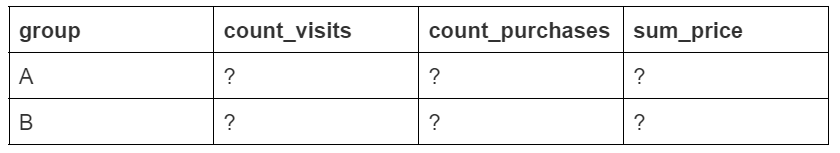

In [221]:
con_data = updated_data.groupby(['group',]).agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).rename(columns={
    'user_id': 'count_visits',
    'purchase': 'count_purchases',
    'price': 'sum_price'
})
display(con_data)

,count_visits,count_purchases,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Вывод 7.5: Разница между выборками составляет 0.05%, можно сказать, что распределение между выборками 50 на 50, т.е. выборка сбалансирована.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [222]:
con_data['conversion'] = con_data['count_purchases'] / con_data['count_visits'] * 100
con_data['mean_check'] = con_data['sum_price'] / con_data['count_purchases']
display(con_data)

,count_visits,count_purchases,sum_price,conversion,mean_check
group,,,,,
A,145307,17487,1417780000,12.034520,81076.228055
B,145381,17290,1533010000,11.892888,88664.545980


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

Вывод 7.6: Из таблицы видно, что в группе A величина конверсии покупки немного больше (~0.14%), чем в группе B. Величины конверсии для групп практически равны. Однако в группе B величина среднего чека покупки на ~8.5% больше чем в группе A.
Возможно, в группе B клиенты в среднем приобретают более дорогие туры.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [223]:
# Сводная таблица - количество продаж от группы и цены тура.
price_group = updated_data.groupby(['price', 'group']).agg(
    {'purchase':'sum'})

# Туры с нулевой ценой (т.е. варианты без покупки) исключены
price_group = price_group[price_group['purchase']!=0]

display(price_group)

purchase
price  group          
10000  A          5182
       B          5201
60000  A          5271
       B          1730
100000 A          1832
       B          5227
150000 A          3478
       B          3438
200000 A          1724
       B          1694

Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

       purchase
group          
A          5271
B          1730


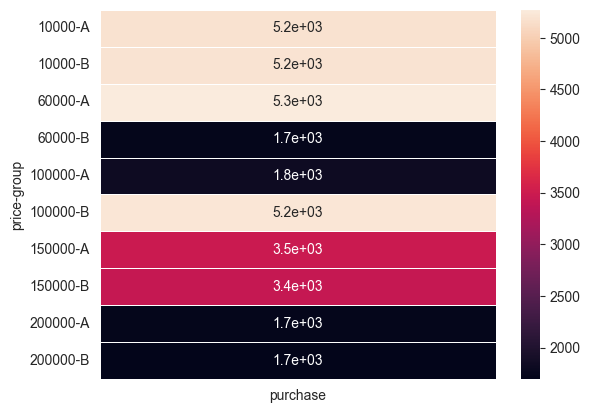

In [224]:
sns.heatmap(price_group, annot=True, linewidths=.5)

print(f'{price_group.loc[60000]}')

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

Вывод 7.7: Можно сделать вывод, что туры на Мальдивы (200кр), Камчатку (150кр) и в Питер (10кр) интересуют покупателей из обеих групп примерно одинаково. Туры в Турцию интересны для группы А в 3 раза больше, чем для группы B. Туры в Таиланд (100кр) почти в три раза больше интересуют участников группы B.

 Тестовый вариант посадочной страницы способствует продаже дорогих туров в Таиланд. Участники группы А предпочитают более экономный вариант с Турцией. По всем остальным вариантам туров поведение покупателей примерно совпадает.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [225]:
# Группировка данных по дате
upd_data_group = updated_data.groupby(['date', 'group']).agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'}).reset_index().rename(columns={'user_id': 'visits'})

# Ежедневные конверсия и средний чек
upd_data_group['daily_conversion'] = round(100*upd_data_group['purchase']/upd_data_group['visits'],2)

upd_data_group['daily_mean_cheque'] = round(upd_data_group['price'] / upd_data_group['purchase'])

upd_data_group.head()

,date,group,visits,purchase,price,daily_conversion,daily_mean_cheque
0,2021-01-02,A,2854,359,29410000,12.58,81922.0
1,2021-01-02,B,2861,345,29660000,12.06,85971.0
2,2021-01-03,A,6596,748,62000000,11.34,82888.0
3,2021-01-03,B,6619,754,65960000,11.39,87480.0
4,2021-01-04,A,6566,799,64250000,12.17,80413.0


In [226]:
upd_data_group[upd_data_group['date']=='2021-01-03'][['date',
                                                      'group',
                                                      'daily_conversion',
                                                      'daily_mean_cheque']]

,date,group,daily_conversion,daily_mean_cheque
2,2021-01-03,A,11.34,82888.0
3,2021-01-03,B,11.39,87480.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [227]:
# Столбец с посещениями
upd_data_group['cum_visits'] = upd_data_group.groupby(
    ['group'])['visits'].cumsum()

# Столбец с числом покупок
upd_data_group['cum_purchase'] = upd_data_group.groupby(
    ['group'])['purchase'].cumsum()

# Столбец с суммой покупок
upd_data_group['cum_price'] = upd_data_group.groupby(
    ['group'])['price'].cumsum()

# конверсия и средний чек
upd_data_group['cum_conversion'] = (upd_data_group['cum_purchase'] /
                                    upd_data_group['cum_visits'] * 100
                                    )

upd_data_group['cum_mean_cheque'] = (upd_data_group['cum_price'] /
                                     upd_data_group['cum_purchase'])

upd_data_group.head()

,date,group,visits,purchase,price,daily_conversion,daily_mean_cheque,cum_visits,cum_purchase,cum_price,cum_conversion,cum_mean_cheque
0,2021-01-02,A,2854,359,29410000,12.58,81922.0,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.06,85971.0,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.34,82888.0,9450,1107,91410000,11.714286,82574.525745
3,2021-01-03,B,6619,754,65960000,11.39,87480.0,9480,1099,95620000,11.592827,87006.369427
4,2021-01-04,A,6566,799,64250000,12.17,80413.0,16016,1906,155660000,11.900599,81668.415530


In [228]:
mask_a = ((upd_data_group['group']=='A') & (upd_data_group['date']=='2021-01-12'))
mask_b = ((upd_data_group['group']=='B') & (upd_data_group['date']=='2021-01-20'))

print('Кумулятивная конверсия в группе B на 20.01.2021г: ', end='')
print(f"{round(float(upd_data_group.loc[mask_b, 'cum_conversion']), 2)} %")

print('Кумулятивный средний чек в группе A на 12.01.2021г: ', end='')
print(f"{round(float(upd_data_group.loc[mask_a, 'cum_mean_cheque']))} р")

Кумулятивная конверсия в группе B на 20.01.2021г: 11.9 %
Кумулятивный средний чек в группе A на 12.01.2021г: 81492 р


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

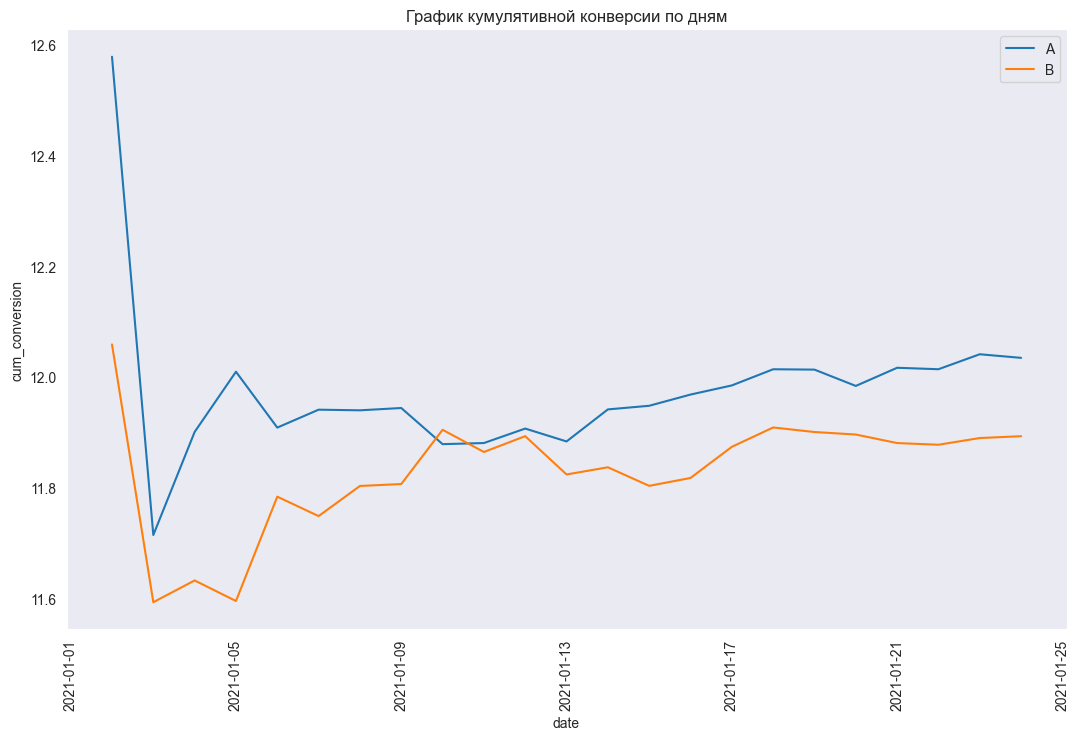

In [229]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_axes([1, 1, 1, 1])

sns.lineplot(
    data=upd_data_group,
    x='date',
    y='cum_conversion',
    hue='group',
    ax=ax
)

ax.set_title('График кумулятивной конверсии по дням')
ax.xaxis.set_tick_params(rotation=90)
ax.legend(['A', 'B'])
ax.grid();

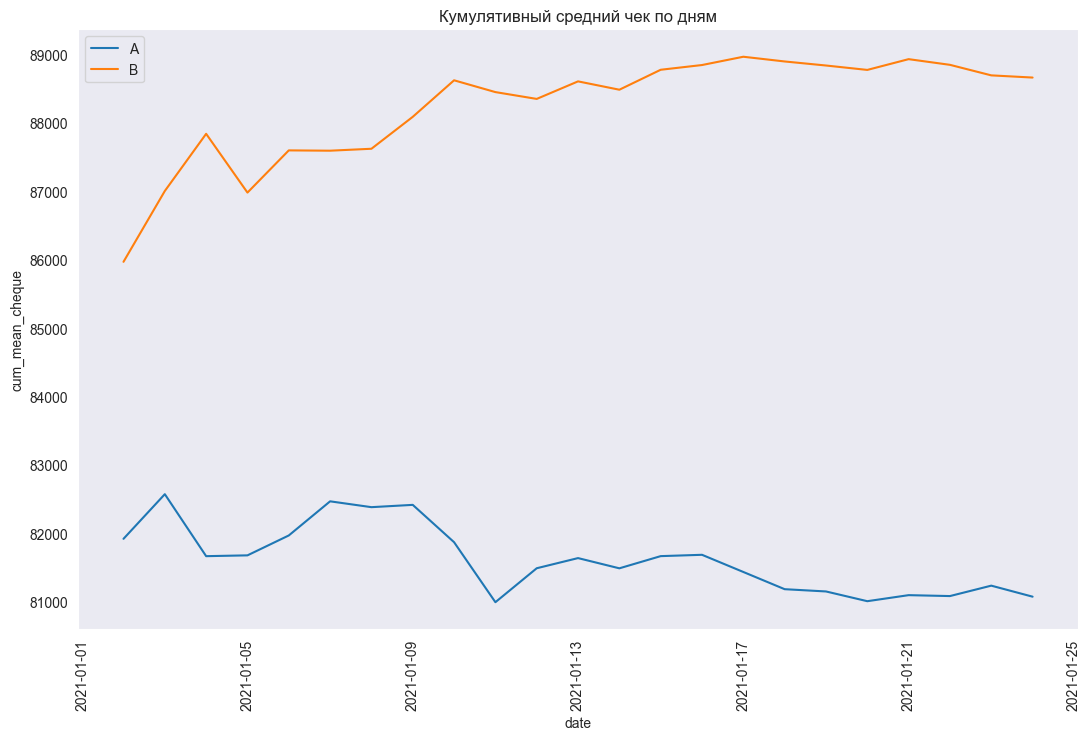

In [230]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_axes([1, 1, 1, 1])

sns.lineplot(
    data=upd_data_group,
    x='date',
    y='cum_mean_cheque',
    hue='group',
    ax=ax
)

ax.set_title('Кумулятивный средний чек по дням')
ax.xaxis.set_tick_params(rotation=90)
ax.legend(['A', 'B'])
ax.grid();

Вывод 7.9: По графику можно сделать вывод, что в начале теста величина была подвержена сильным колебаниям, однако ближе к концу периода тестирование происходит стабилизация метрики. Конверсия группы A несколько больше, но не значительно.

Величина кумулятивного среднего чека для группы A с начала теста снижается, а для группы B, увеличивается. Средний чек для группы A больше, чем для группы B. Максимальная разница между показателями достигается к концу теста. Значения к концу теста также стабилизируются.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [231]:
# количество успехов и наблюдений
converted_piv = updated_data.groupby('group').agg({
    'user_id': 'count', 'purchase': 'sum'})

converted_piv

,user_id,purchase
group,,
A,145307,17487
B,145381,17290


In [232]:
# Гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше чем конверсия в группе B'

# Уровень значимости
alpha = 0.05

# p-value для z-теста для пропорции
_, p_value = proportions_ztest(
    count=converted_piv['purchase'], # число "успехов"
    nobs=converted_piv['user_id'], # число наблюдений
    alternative='larger',
)

print('p-value: ', round(p_value, 2))

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

Вывод 7.10: Для проверки гипотезы о равенстве конверсий используется z-тест. По результатам проведения теста подтвердилась нулевая гипотеза об отсутствии различий между конверсиями для групп A и B.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [233]:
def proportions_conf_interval(n, x_p, gamma=0.95):
    '''
    Расчет границ доверительного интервала для пропорции
    n - размер выборки
    x_p - выборочная пропорция
    gamma - доверительный интервал
    '''
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 # погрешность
    lower_bound = x_p - eps # левая граница
    upper_bound = x_p + eps # правая граница
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

def diff_proportions_conf_interval(n, xp, gamma=0.95):
    '''
    Расчет границ доверительного интервала для разницы пропорций
    n - список размеров выборок
    x_p - список выборочных пропорций
    '''
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z-критическое
    diff = xp[1] - xp[0] # выборочная разница конверсий для групп
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая граница
    upper_bound = diff + eps # приавая граница
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

a_data = updated_data[updated_data['group']=='A']
b_data = updated_data[updated_data['group']=='B']

interval_a = proportions_conf_interval(
    n=a_data['user_id'].count(),
    x_p=a_data['purchase'].mean()
)

interval_b = proportions_conf_interval(
    n=b_data['user_id'].count(),
    x_p=b_data['purchase'].mean()
)

print(f'Доверительный интервал для конверсии группы A: {interval_a}')
print(f'Доверительный интервал для конверсии группы B: {interval_b}')

n_ab = [a_data['user_id'].count(), b_data['user_id'].count()]
xp_ab = [a_data['purchase'].mean(), b_data['purchase'].mean()]

diff_interval = diff_proportions_conf_interval(n_ab, xp_ab)

print(f'Доверительный интервал для разности конверсий: {diff_interval}')

Доверительный интервал для конверсии группы A: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)
Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

Вывод 7.11: Доверительный интевал для разности конверсий включает в себя нулевое значение. Отсюда можно сделать вывод, что варианты A и B равнозначны по метрике конверсии. Истинная разница в конверсии может быть как положительна, так и отрицательна, но при этом близка к нулю.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

Text(0.5, 1.0, 'Распределение среднего чека в группе B')

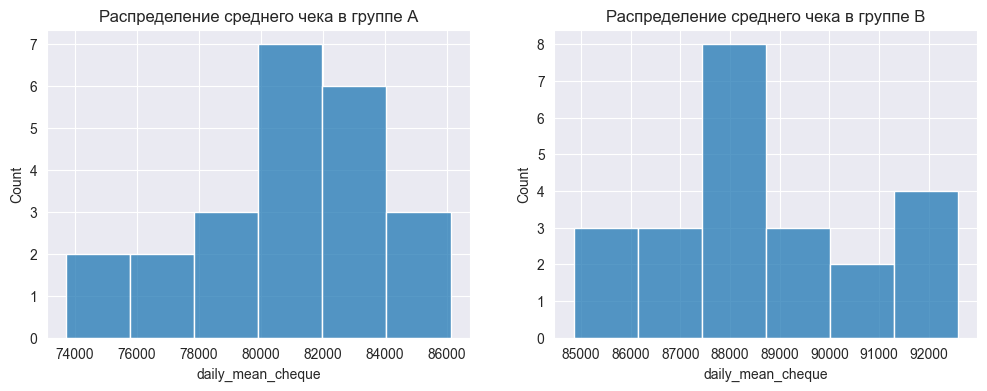

In [234]:
# средний ежедневный чек
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(x='daily_mean_cheque',
             data=upd_data_group[upd_data_group['group']=='A'],
             ax=axes[0])
sns.histplot(x='daily_mean_cheque',
             data=upd_data_group[upd_data_group['group']=='B'],
             ax=axes[1])

axes[0].set_title('Распределение среднего чека в группе А')
axes[1].set_title('Распределение среднего чека в группе B')

In [235]:
# Гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение отлично от нормального'

# Уровень значимости
alpha = 0.05

# тест Шапиро-Уилка
shapiro_dcheque_a = shapiro(upd_data_group[upd_data_group['group']=='A']['daily_mean_cheque'])
shapiro_dcheque_b = shapiro(upd_data_group[upd_data_group['group']=='B']['daily_mean_cheque'])

print('p-value группы А', round(shapiro_dcheque_a.pvalue, 2))
print('p-value группы B', round(shapiro_dcheque_b.pvalue, 2))

if ((shapiro_dcheque_a.pvalue < alpha) or (shapiro_dcheque_b.pvalue < alpha)):
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


Вывод 7.12: Для проверки гипотезы о нормальности распределения ежедневного среднего чека для обеих групп используется тест Шапиро-Уилка. С уровнем значимости 0.05 распределения для обеих группах нормальные.

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [236]:
# Гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B'

# Уровень значимости
alpha = 0.05

# t-тест
ttest_mean_dcheque = ttest_ind(
    a=upd_data_group[upd_data_group['group']=='A']['daily_mean_cheque'],
    b=upd_data_group[upd_data_group['group']=='B']['daily_mean_cheque'],
    alternative='less'
)

print('p-value', round(ttest_mean_dcheque.pvalue, 2))

if ttest_mean_dcheque.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value 0.0
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

Вывод 7.13: Для проверки гипотезы о равенстве средних ежедневных чеков используется t-тест. Согласно его результатам нулевая гипотеза может быть отвергнута, таким образом: Ежедневный средний чек в группе A меньше чем в B.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [237]:
def tcrit_mean_interval(n, x_mean, x_std, gamma=0.95):
    '''
    Доверительный интервал для среднего, t-распределение
    n - размер выборки
    x_mean - выборочное среднее
    x_std - выборочное стандартное отклонение
    gamma - уровень надежности
    '''

    k = n - 1 # Число степеней свободы
    alpha = 1 - gamma # Уровень значимости
    t_crit = -t.ppf(alpha/2, k) # t-критическое
    eps = t_crit * x_std / (n**0.5) # Погрешность
    lower_bound = round(x_mean - eps)
    upper_bound = round(x_mean + eps)
    return lower_bound, upper_bound

In [238]:
mean_std_data = upd_data_group.groupby('group')['daily_mean_cheque'].agg(('mean', 'std'))

mean_std_data

,mean,std
group,,
A,80969.347826,3096.388506
B,88575.739130,2196.705844


In [239]:
interval_a = tcrit_mean_interval(
    n=upd_data_group[upd_data_group['group']=='A'].shape[0],
    x_mean=mean_std_data.loc['A', 'mean'],
    x_std=mean_std_data.loc['A', 'std'])

interval_b = tcrit_mean_interval(
    n=upd_data_group[upd_data_group['group']=='B'].shape[0],
    x_mean=mean_std_data.loc['B', 'mean'],
    x_std=mean_std_data.loc['B', 'std'])

print('Доверительный интервал для среднего дневного чека для A: ', end='')
print(f'{interval_a}')

print('Доверительный интервал для среднего дневного чека для B: ', end='')
print(f'{interval_b}')

Доверительный интервал для среднего дневного чека для A: (79630, 82308)
Доверительный интервал для среднего дневного чека для B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Вывод 7.14: Пересечение между доверительными интервалами для ежедневных средних чеков для обеих групп отсутствует. Истинные средние значения не совпадут.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему?

По результатам проведения A/B тестирования можно сделать следующие выводы:

- выбор варианта страницы не влияет на конверсию покупки тура на сайте - следует из подтверждения гипотезы о равенстве конверсии;
- предыдущий вывод также подтверждается тем, что границы интервала для разности конверсий имеют различные знаки;
- тестовый вариант B ведет к увеличению ежедневного среднего чека - это следует из опровержения гипотезы о равенстве средних ежедневных чеков;
- также предыдущий вывод подтверждается отсутствием пересечения доверительных интервалов для истинных средних ежедневных чеков.

Дделаем вывод: вариант стартовой страницы B является более предпочтительным для дальнейшего использования.